In [1]:
pwd

'c:\\Users\\ofir1\\Msc\\object-detection-nn\\nn\\YOLO_VGG16\\degug_notebooks'

In [2]:
cd object-detection-nn

/home/dcor/niskhizov/Rar/object-detection-nn


In [2]:
cd ../../..

c:\Users\ofir1\Msc\object-detection-nn


In [3]:
remote_mode = False

import sys
import os

from nn.YOLO_VGG16 import training_loop
from nn.YOLO_VGG16.utils.constants import ANCHORS
from nn.YOLO_VGG16.prepare_data.coco_dataset import CocoDataset
from nn.YOLO_VGG16.prepare_data.transforms import train_transform, test_transform
from nn.YOLO_VGG16.utils.helpers import convert_cells_to_bboxes, load_checkpoint, nms, plot_image, save_checkpoint
from nn.YOLO_VGG16.utils.constants import device, s, leanring_rate, save_model, checkpoint_file
from nn.YOLO_VGG16.model.YOLO_VGG16_full import YOLO_VGG16_F
import torch
import torch.optim as optim
from nn.YOLO_VGG16.model.loss import YOLOLoss
from pycocotools.coco import COCO
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T

if remote_mode:
    model_path_base = f"/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/vgg_f_airplain_model"
    coco_path = lambda type: f'/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/temp/instances_{type}2017.json'
else:
    model_path_base = f"nn/YOLO_VGG16/degug_notebooks/"
    coco_path = lambda type: f'nn/cocodataset/annotations/instances_{type}2017.json'


c:\Users\ofir1\anaconda3\envs\object-detection\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
coco = COCO(coco_path('train'))
categories = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
] # 80 classes of COCO dataset


loading annotations into memory...
Done (t=25.29s)
creating index...
index created!


In [5]:
# Creating the model from YOLOv3 class 
load_model = False
model = YOLO_VGG16_F(num_classes=len(categories)).to(device) 

# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 

# Defining the loss function 
loss_fn = YOLOLoss() 

# Defining the scaler for mixed precision training 
scaler = torch.amp.GradScaler(device=device) 
# Loading the checkpoint 
if load_model: 
    load_checkpoint(model_path_base + f"e49_vgg16_{checkpoint_file}", model, optimizer, leanring_rate, device) 

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/YOLO_VGG16_F_Airplane')



In [6]:
dataset = CocoDataset( 
	coco_obj=coco, 
	categories=categories,
	grid_sizes=[13, 26, 52], 
	anchors=ANCHORS, 
	transform=train_transform 
) 

# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
	dataset=dataset, 
	batch_size=8, 
	shuffle=True, 
) 


In [7]:
# Load the validation dataset
val_coco = COCO(coco_path('val'))

val_dataset = CocoDataset(
    coco_obj=val_coco,
    categories=categories,
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform  # Use the same transform for validation
)

# Create the validation data loader
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=True,
)

val_loader_iter = iter(val_loader)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [8]:
# Scaling the anchors 
scaled_anchors = ( 
	torch.tensor(ANCHORS) *
	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 

Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

batch_idx: 0


  0%|          | 0/1 [00:07<?, ?it/s, loss=25]

==> Saving checkpoint


100%|██████████| 1/1 [00:08<00:00,  8.11s/it, loss=25]


display and report image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


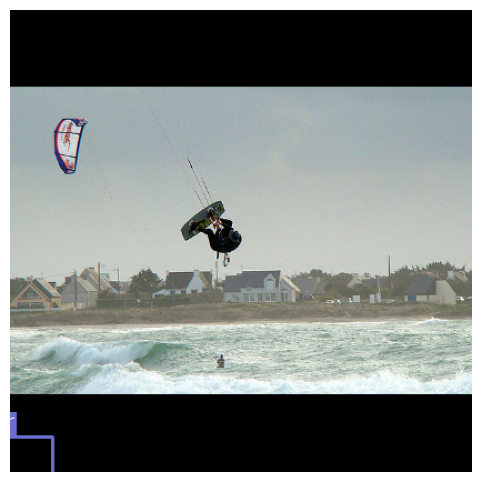

Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

batch_idx: 0


  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
epochs = 100000000
# Training the model 
for e in range(1, epochs+1): 
	print("Epoch:", e) 
    ################# dos
    # Creating a progress bar 
	progress_bar = tqdm(train_loader, leave=True) 

	# Initializing a list to store the losses 
	losses = [] 

	# Iterating over the training data 
	for batch_idx, (x, y) in enumerate(progress_bar): 
		print("batch_idx:", batch_idx)
		x = x.to(device) 
		y0, y1, y2 = ( 
			y[0].to(device), 
			y[1].to(device), 
			y[2].to(device), 
		) 

		with torch.amp.autocast(device_type=device): 
			# Getting the model predictions 
			outputs = model(x) 
			# Calculating the loss at each scale 
			loss = ( 
				loss_fn(outputs[0], y0, scaled_anchors[0]) 
				+ loss_fn(outputs[1], y1, scaled_anchors[1]) 
				+ loss_fn(outputs[2], y2, scaled_anchors[2]) 
			) 

		# Add the loss to the list 
		losses.append(loss.item()) 

		# Reset gradients 
		optimizer.zero_grad() 

		# Backpropagate the loss 
		scaler.scale(loss).backward() 

		# Optimization step 
		scaler.step(optimizer) 

		# Update the scaler for next iteration 
		scaler.update() 

		# update progress bar with loss 
		mean_loss = sum(losses) / len(losses) 
		progress_bar.set_postfix(loss=mean_loss)
  
        # Log the loss to TensorBoard
		writer.add_scalar('Loss/train', mean_loss, e * len(train_loader) + batch_idx)

		# Log images to TensorBoard every 100 batches
		if batch_idx % 200 == 0:
			# Saving the model 
			if save_model: 
				save_checkpoint(model, optimizer, filename=model_path_base +f"b{batch_idx}_vgg16_checkpoint.pth.tar")

   
	# Saving the model 
	if save_model: 
		save_checkpoint(model, optimizer, filename=model_path_base +f"e{e}_vgg16_checkpoint.pth.tar")
        # delete batch checkpoints
		for i in range(0, batch_idx+1, 200):
			os.remove(model_path_base + f"b{i}_vgg16_checkpoint.pth.tar")
		# for i in range(0,e-3):
		# 	if os.path.exists(model_path_base + f"e{i}_vgg16_checkpoint.pth.tar"):
		# 		os.remove(model_path_base + f"e{i}_vgg16_checkpoint.pth.tar")
   
	model.eval()
 
	# Getting a sample image from the test data loader 
	try:
		x, y = next(val_loader_iter)
	except StopIteration:
		val_loader_iter = iter(val_loader)
		x, y = next(val_loader_iter)
	x = x.to(device) 
	
	print("display and report image")
	with torch.no_grad():
		output = model(x)
		y0, y1, y2 = ( 
			y[0].to(device), 
			y[1].to(device), 
			y[2].to(device), 
		) 

		with torch.amp.autocast(device_type=device): 
			# Getting the model predictions 
			outputs = model(x) 
			# Calculating the loss at each scale 
			loss = ( 
				loss_fn(outputs[0], y0, scaled_anchors[0]) 
				+ loss_fn(outputs[1], y1, scaled_anchors[1]) 
				+ loss_fn(outputs[2], y2, scaled_anchors[2]) 
			) 
   
		writer.add_scalar('Loss/val', loss.item(), e)
  
		bboxes = [[] for _ in range(x.shape[0])]
		for i in range(3):
			batch_size, A, S, _, _ = output[i].shape
			anchor = scaled_anchors[i]
			boxes_scale_i = convert_cells_to_bboxes(output[i], anchor, s=S, is_predictions=True)
			for idx, box in enumerate(boxes_scale_i):
				bboxes[idx] += box
		i = 0
		nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6)
		img_with_boxes = plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, categories)
		img_with_boxes = T.ToTensor()(img_with_boxes)
		writer.add_image(f'Val/Image_{e}_{i}_before', img_with_boxes, e * len(train_loader) + batch_idx)

	model.train()


    #################
	# training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
